In [1]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from markdown2 import markdown
from bs4 import BeautifulSoup
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.lda_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


# Path to the ADR directory
adr_directory = "../../data/ADRs-Updated"

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Considerations

- Max sequence length --> if records are longer than 512 --> split them up and aggregate?
- Feature Augmentation: Combine text embeddings with other features if available (e.g., metadata).
- Clean up text --> remove common words, phrases, keep only what has meaning for better clustering --> use libraries to remove markdown elements, common words etc
- See interpretation for clusters etc --> read papers on that

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# these produce good results
# if we exclude more words, the results are not as good
unwanted_terms = ["context", "decision", "status", "consequences", "consequences", "michael"
                     "motivation", "options", "option", "alternatives", "need" , "adr"
                       "alternative", "nygard", "nygards", "use", "using" , "used", "accepted", "date"]


def clean_text(markdown_content):
    # Convert Markdown to HTML
    html_content = markdown(markdown_content)
    # Parse HTML to text
    soup = BeautifulSoup(html_content, "html.parser")
    text = soup.get_text()
    # Remove non-alphabetic characters and lower the case
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize, remove stop words, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    # remove words with less than 3 characters
    tokens = [word for word in tokens if len(word) > 2]
    # remove common terms and words that are are present in every document and do not provide any information
    tokens = [word for word in tokens if word not in unwanted_terms]
    return ' '.join(tokens)


## Clean text

In [3]:
cleaned_texts = []
# Read, preprocess, and encode each ADR file
count = 0
total_files = len(os.listdir(adr_directory))
for file_name in os.listdir(adr_directory):
    if file_name.endswith('.md'):
        file_path = os.path.join(adr_directory, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            preprocessed_text = clean_text(text)
            cleaned_texts.append(preprocessed_text)
            # save the preprocessed text to a file with the same filename in another directory
            # with open(f"../../data/ADRs-Cleaned/{file_name}", 'w') as preprocessed_file:
            #     preprocessed_file.write(preprocessed_text)

## Embed with huggingface sequence transformers

In [ ]:
# Load a pre-trained model from sentence-transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# List to store filenames and their corresponding embeddings
data = []

for count, text in enumerate(cleaned_texts):
    embedding = model.encode(text)
    print(f"Embedding {count+1}/{total_files} has been generated.")
    data.append(embedding)

print("Embeddings have been successfully saved.")

X = np.array(data)

## Embed with doc2vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Step 3: Prepare Data for Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(cleaned_texts)]

# Step 4: Train Doc2Vec Model
model = Doc2Vec(vector_size=500, window=5, min_count=2, workers=10, epochs=100)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# Step 5: Generate Embeddings for Each Document
embeddings = [model.dv[i] for i in range(len(documents))]

# Check the shape of the embeddings to confirm
embeddings = np.array(embeddings)
print(embeddings.shape)  # (number_of_documents, embedding_dimension)

X = embeddings


## Embed with TF-IDF

In [ ]:

# max df is --> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
# min df is --> When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2, max_features=5000)
X = vectorizer.fit_transform(cleaned_texts)

## Topic Modelling

Topic models thereby aim to uncover the latent topics or themes characterizing a set of documents. In this way, topic models are a machine learning-based form of text analysis used to thematically annotate large text corpora

## TF-IDF + LDA (hyperparameters obtained from grid search)

In [5]:
from sklearn.decomposition import LatentDirichletAllocation

# good results: 
# 1) n_components=4, learning_decay=0.5, learning_offset=10, max_df=0.9, min_df=5, max_features=2000
# 2) n_components=5, learning_decay=0.5, learning_offset=10, max_df=0.9, min_df=5, max_features=2000
# 3) n_components=4, learning_decay=0.5, learning_offset=10, max_df=0.9, min_df=5, max_features=1000

# Notes: From hyperparam tuning
# n_components=4, learning_decay=0.5, learning_offset=10, max_df=0.9, min_df=5, max_features=1000

# Define the vectorizer and LDA model
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5, max_features=1000)
lda = LatentDirichletAllocation(n_components=4, learning_decay=0.5, learning_offset=10, n_jobs=-1, max_iter=50)

X = tfidf_vectorizer.fit_transform(cleaned_texts)

lda.fit(X)

LatentDirichletAllocation(learning_decay=0.5, learning_offset=10, max_iter=50,
                          n_components=4, n_jobs=-1)

# Prominent Topics
- Topic 1: Cloud and Infrastructure --> prevalent in all tries
- Topic: Data and data storage --> prevalent in almost all tries
- Topic 2: Programming language and frameworks --> Have to dig in a bit with different hyperparameters
- Topic 3: Authentication and Security --> have to dig in a bit with different hyperparameters
- Topic 4: General architecrture and design (classes, apis)--> prevalent in all tries --> maybe focus on this and split up into different topics
- Topic 5: Linting, formating and conventions --> have to dig in a bit with different hyperparameters
- Topic 6: Building and releasing (CI/CD, Testing) --> have to dig in a bit with different hyperparameters
- Topic 7: ADRs about architectiral decisions --> seen with >4 topics

## Evaluate TF-IDF + LDA

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 20
print_top_words(lda, tfidf_vectorizer.get_feature_names_out(), n_top_words)

print("\n\nDistributions")
# see hoe many documents are in each topic
topic_distribution = lda.transform(X)
for i in range(4):
    print(f"Topic {i}: {np.sum(topic_distribution[:, i])}" + f" ({np.sum(topic_distribution[:, i]) / len(cleaned_texts) * 100:.2f}%)")

Topic 0:
data api event type message user file object model value database request new field change error function client state service
Topic 1:
service aws user application cluster access kubernetes cloud platform authentication environment terraform instance infrastructure account security container data server resource
Topic 2:
image version release package file repository docker branch build github git environment pipeline dependency license deployment project run code npm
Topic 3:
component test code project framework library consequence good architecture language tool react testing support application change style javascript python team


Distributions
Topic 0: 1970.8381693610168 (36.96%)
Topic 1: 1054.3970012193022 (19.77%)
Topic 2: 702.1774378076725 (13.17%)
Topic 3: 1605.5873916120083 (30.11%)


In [7]:
# Prepare to visualize
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, tfidf_vectorizer, mds='tsne')
pyLDAvis.display(panel)

## Hyperparameter tuning for LDA and TF-IDF

In [ ]:
# Define the vectorizer and LDA model
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
lda = LatentDirichletAllocation(random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lda', lda)
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000],
    'lda__n_components': [4, 5, 6, 7, 8, 9, 10],
    'lda__learning_decay': [0.5, 0.7, 0.9],
    'lda__learning_offset': [10, 15, 20, 30]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(cleaned_texts)

# Evaluate the best model
print("Best Parameters: ", grid_search.best_params_)
best_lda_model = grid_search.best_estimator_

# Print top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.named_steps['lda'].components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 10
tfidf_feature_names = grid_search.best_estimator_.named_steps['tfidf'].get_feature_names_out()
print_top_words(best_lda_model, tfidf_feature_names, n_top_words)

## Top2Vec

In [6]:
from top2vec import Top2Vec

# Initialize and train the Top2Vec model
# change to deep-learn for higher quality embeddings
model = Top2Vec(cleaned_texts, embedding_model='doc2vec', min_count=5, speed='deep-learn', workers=20)


2024-06-05 18:27:49,581 - top2vec - INFO - Pre-processing documents for training
2024-06-05 18:27:50,643 - top2vec - INFO - Creating joint document/word embedding
2024-06-05 18:36:56,579 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-05 18:36:58,953 - top2vec - INFO - Finding dense areas of documents
2024-06-05 18:36:59,047 - top2vec - INFO - Finding topics


In [7]:
# save model
model.save("top2vec_model")

In [9]:
model.hierarchical_topic_reduction(10)

[[77, 66, 3, 24, 76, 60, 30, 43, 9, 34, 28, 40, 37, 10, 33, 63, 71, 1],
 [44, 72, 2, 18, 27, 35, 65, 6],
 [47, 73, 13, 20, 26, 32, 54, 68, 8],
 [74, 41, 31, 62, 64, 5],
 [19, 69, 17, 14, 59, 36, 57, 12],
 [21, 70, 53, 39, 50, 46, 48, 52, 22],
 [49, 75, 38, 56, 55, 67, 0],
 [15, 16, 29, 58, 4],
 [42, 51, 45, 61, 25],
 [11, 23, 7]]

Topic 1:
style, linting, javascript, webpack, typescript, jest, developer, react, styling, learn
Topic 2:
throw, method, httpclientts, methodclass, loginrequired, saleschannelapi, dbal, type, tagv, equality
Topic 3:
staff, dxws, government, whitehall, warehouse, pharmacy, finance, backdating, supplier, mainstream
Topic 4:
java, gradle, eclipse, intellij, epl, spring, copyright, accompanying, ide, groovy
Topic 5:
terraform, cluster, aws, kubernetes, dns, provision, balancer, ingres, vpc, provisioning
Topic 6:
jwt, oauth, session, expiry, token, authentication, oidc, cookie, cooky, cassandra
Topic 7:
docker, container, image, deployment, dockerfile, cicd, alpine, kubernetes, running, dockerhub
Topic 8:
ddd, cqrs, domaindriven, layered, business, hexagonal, layer, architecture, tactical, anemic
Topic 9:
game, fragment, timerstep, monadstate, screen, navigation, viewmodel, redux, spawntimer, looptimer
Topic 10:
branch, merge, merged, motivating, constrains, dependabot, hotfixes, github, pr

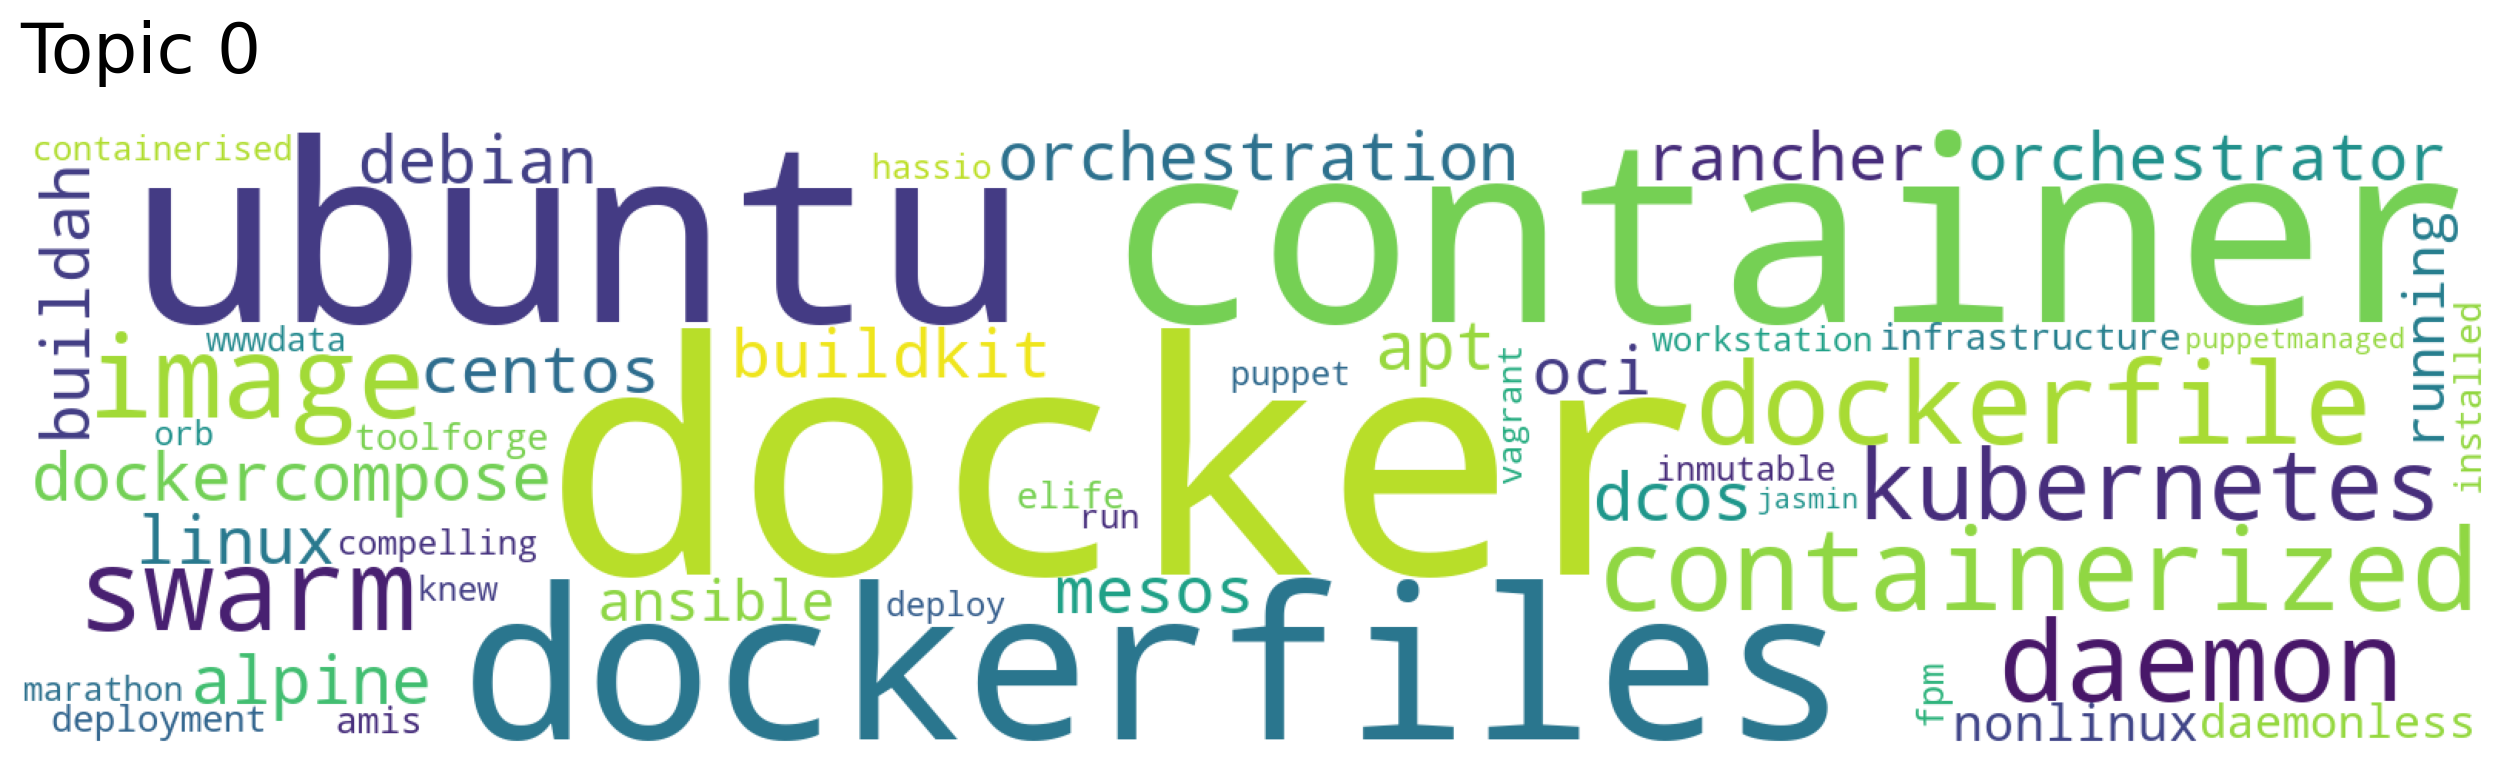

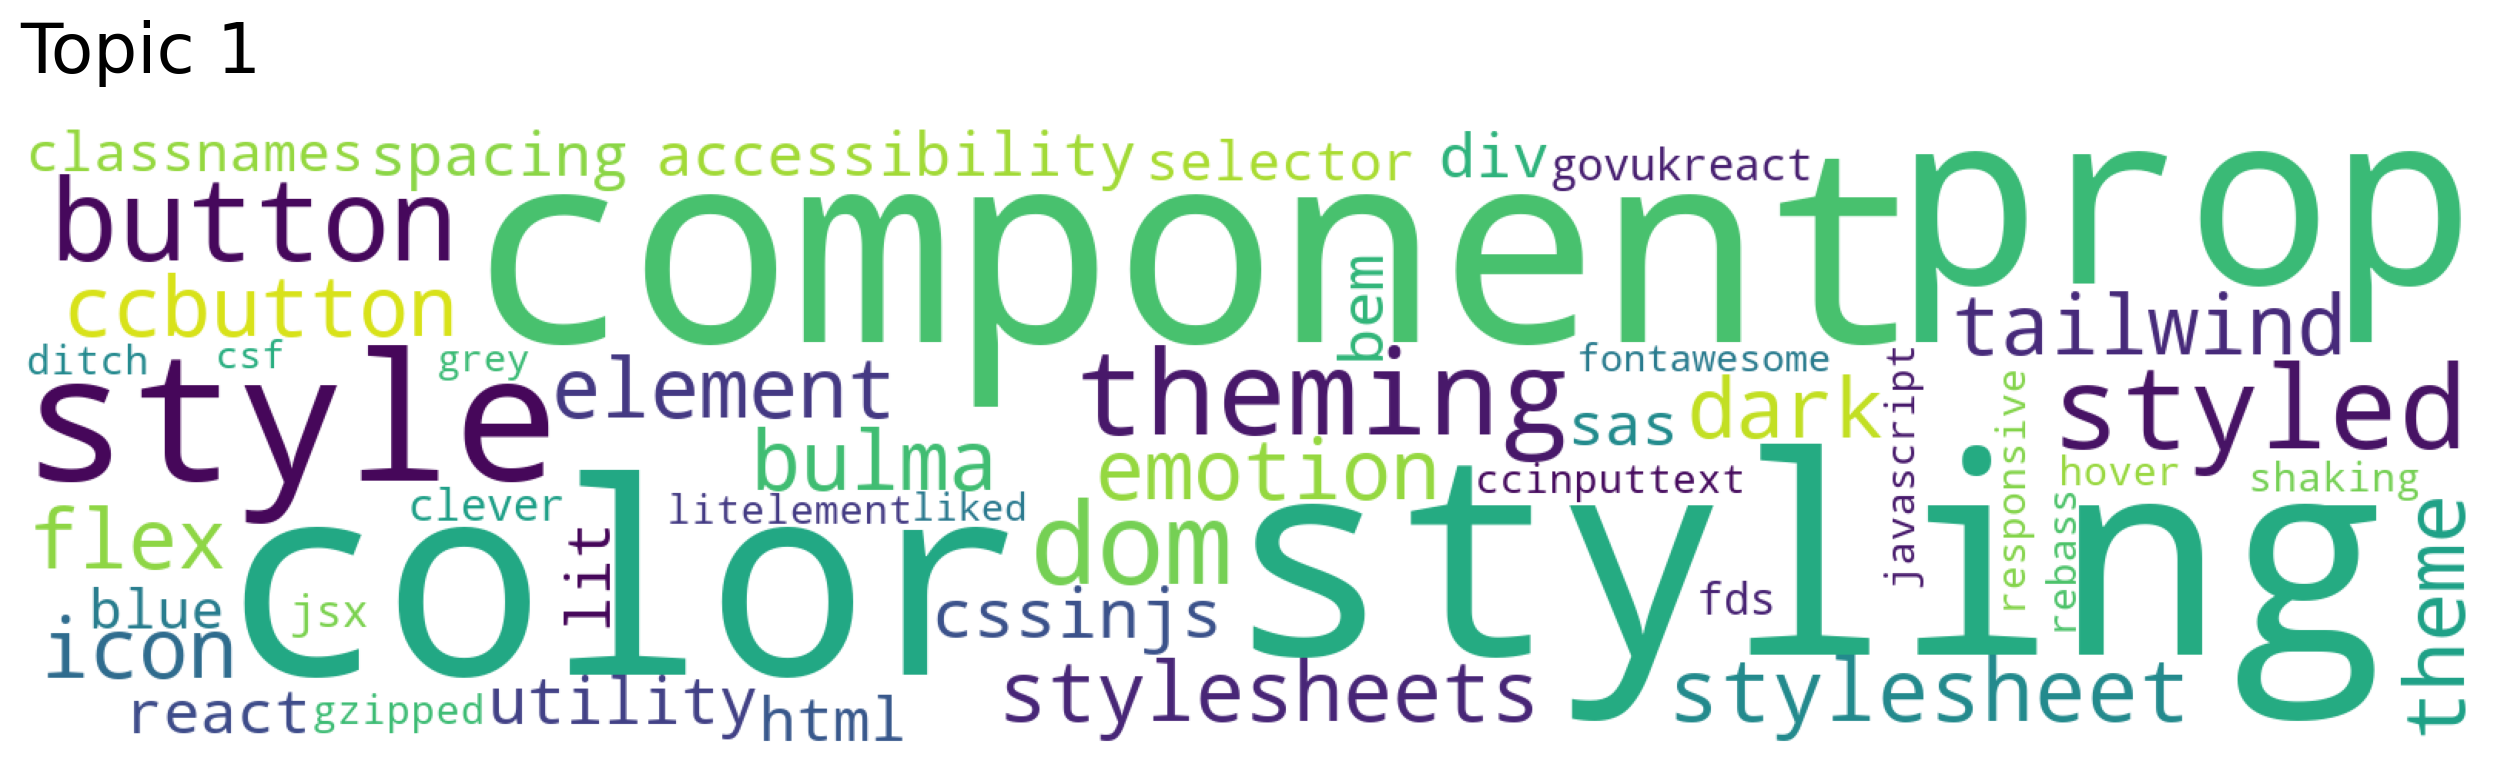

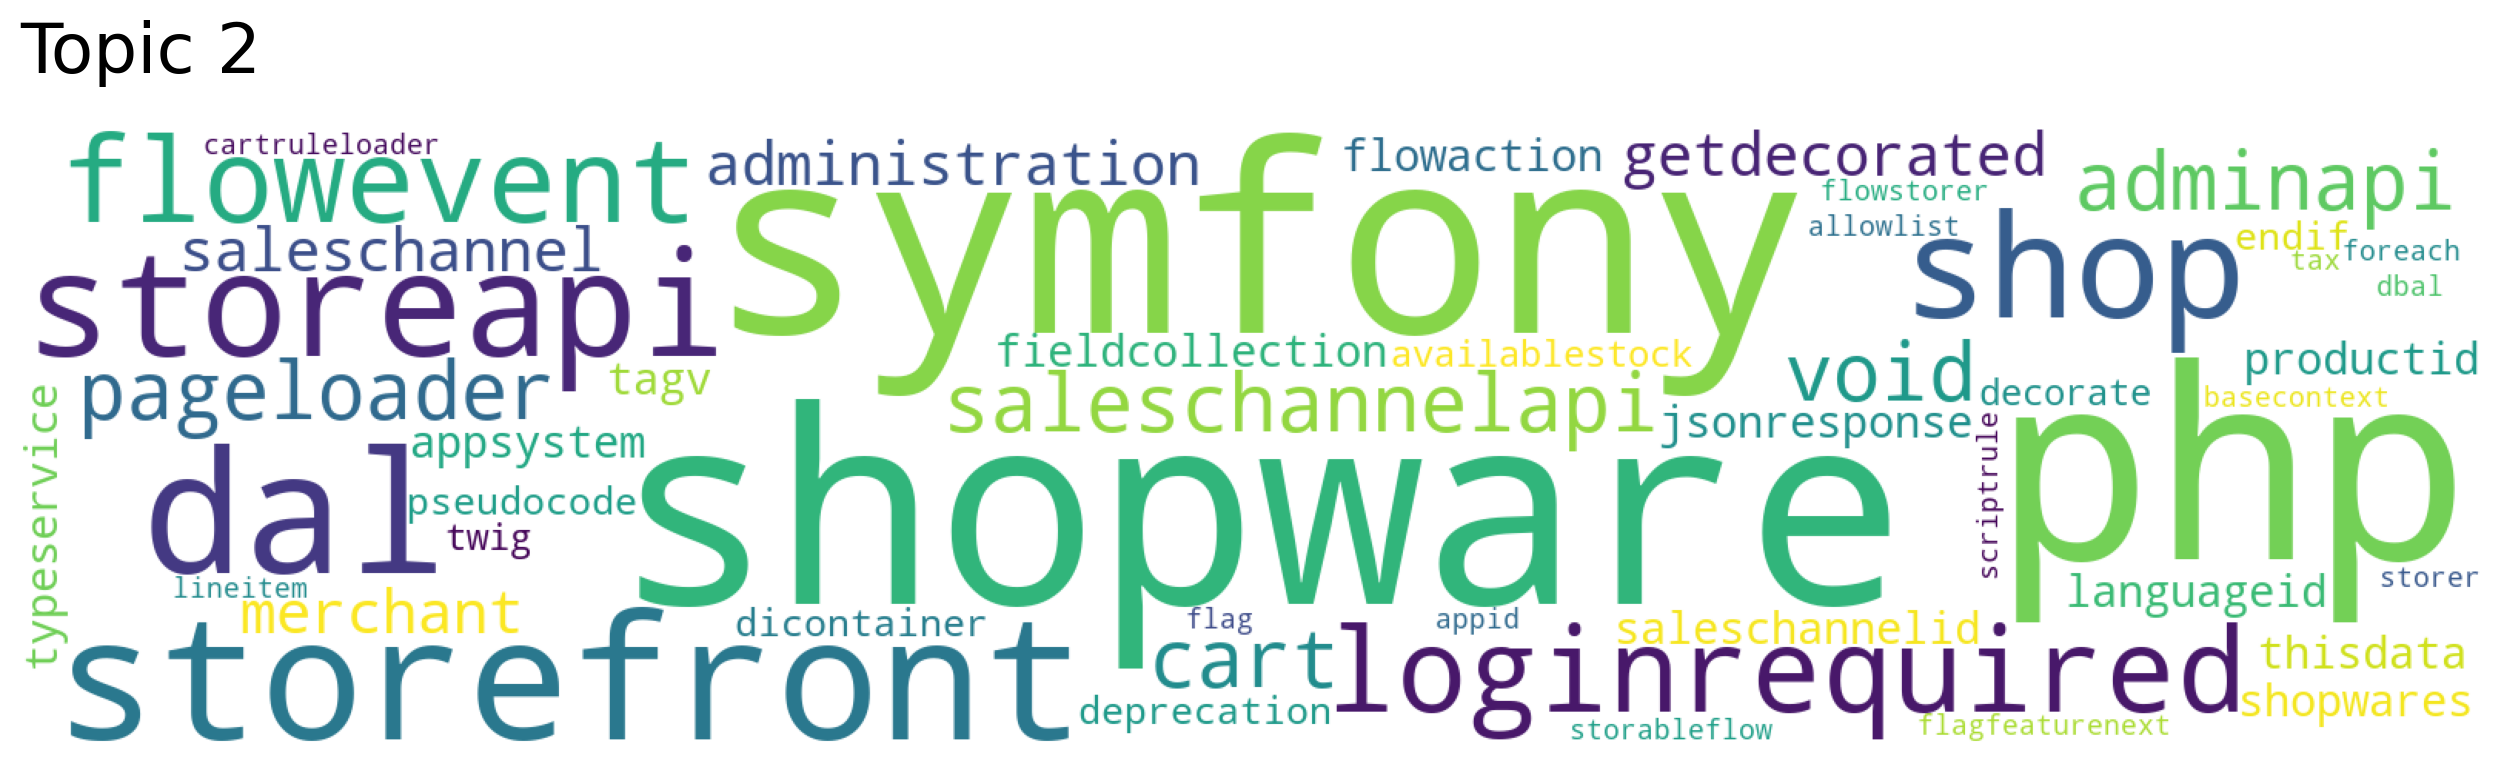

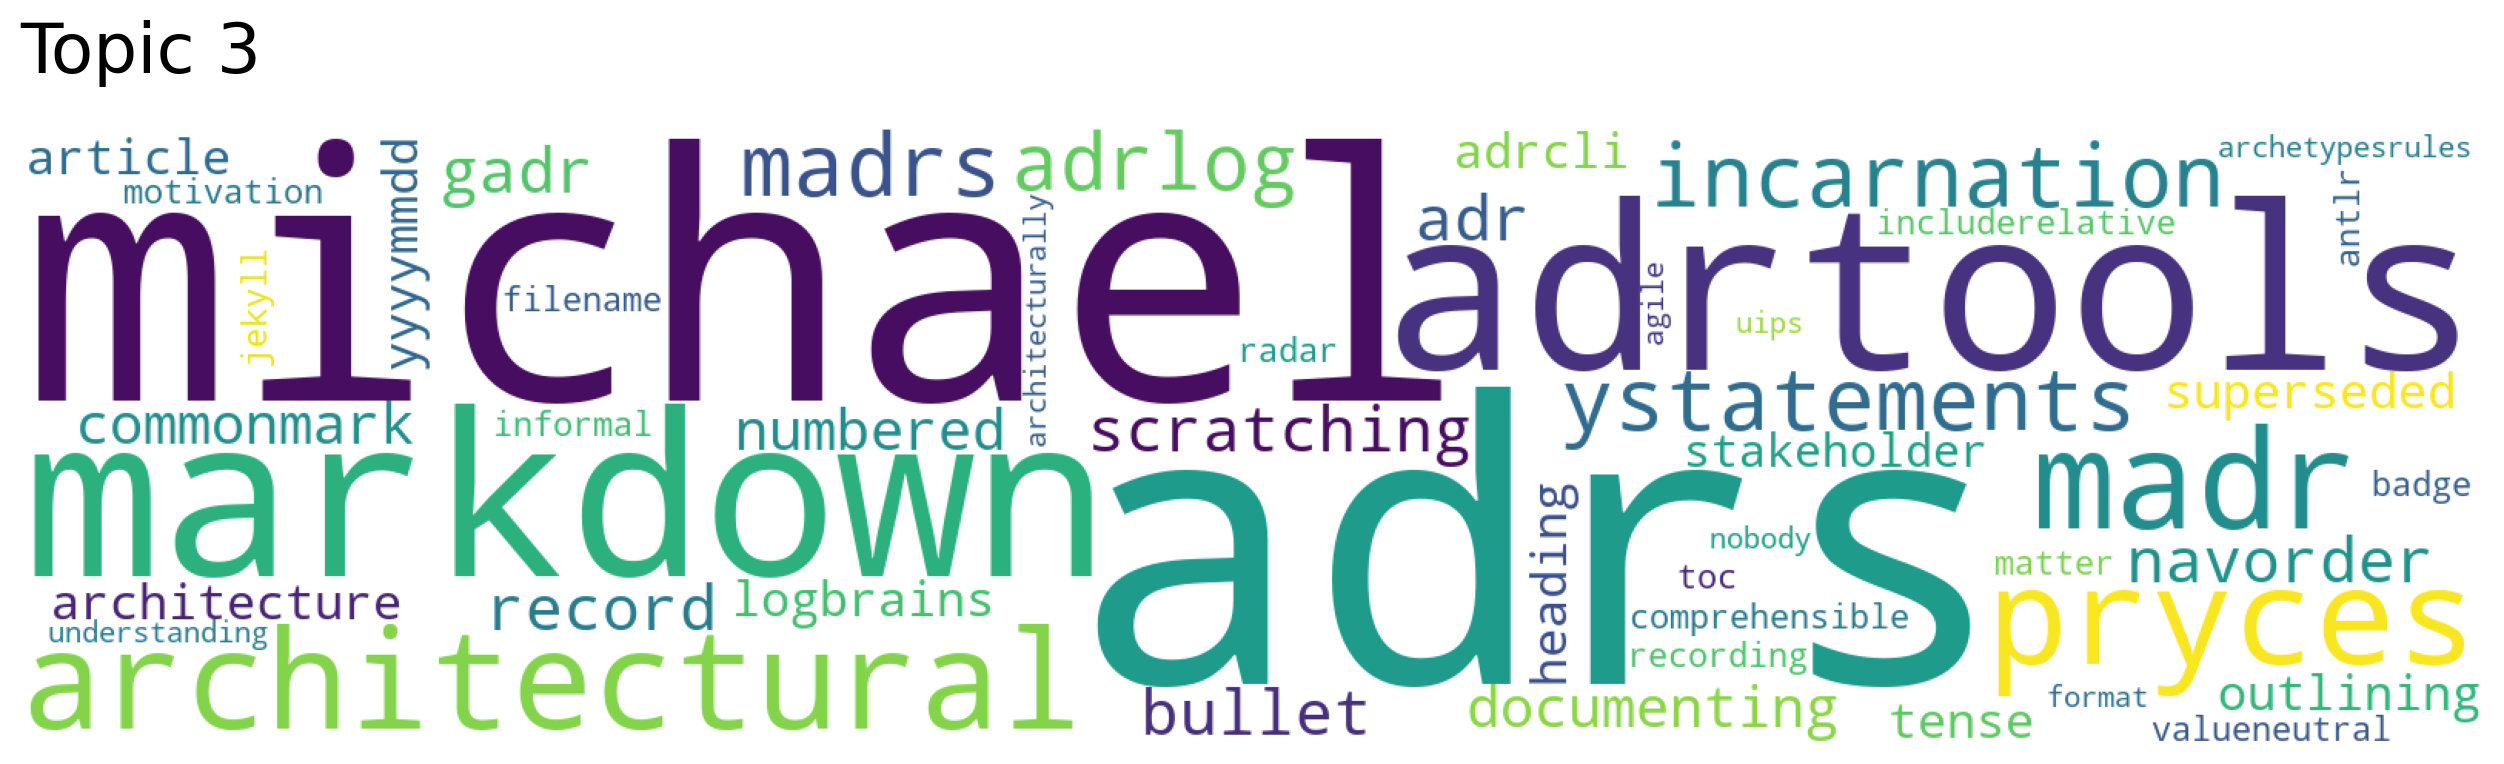

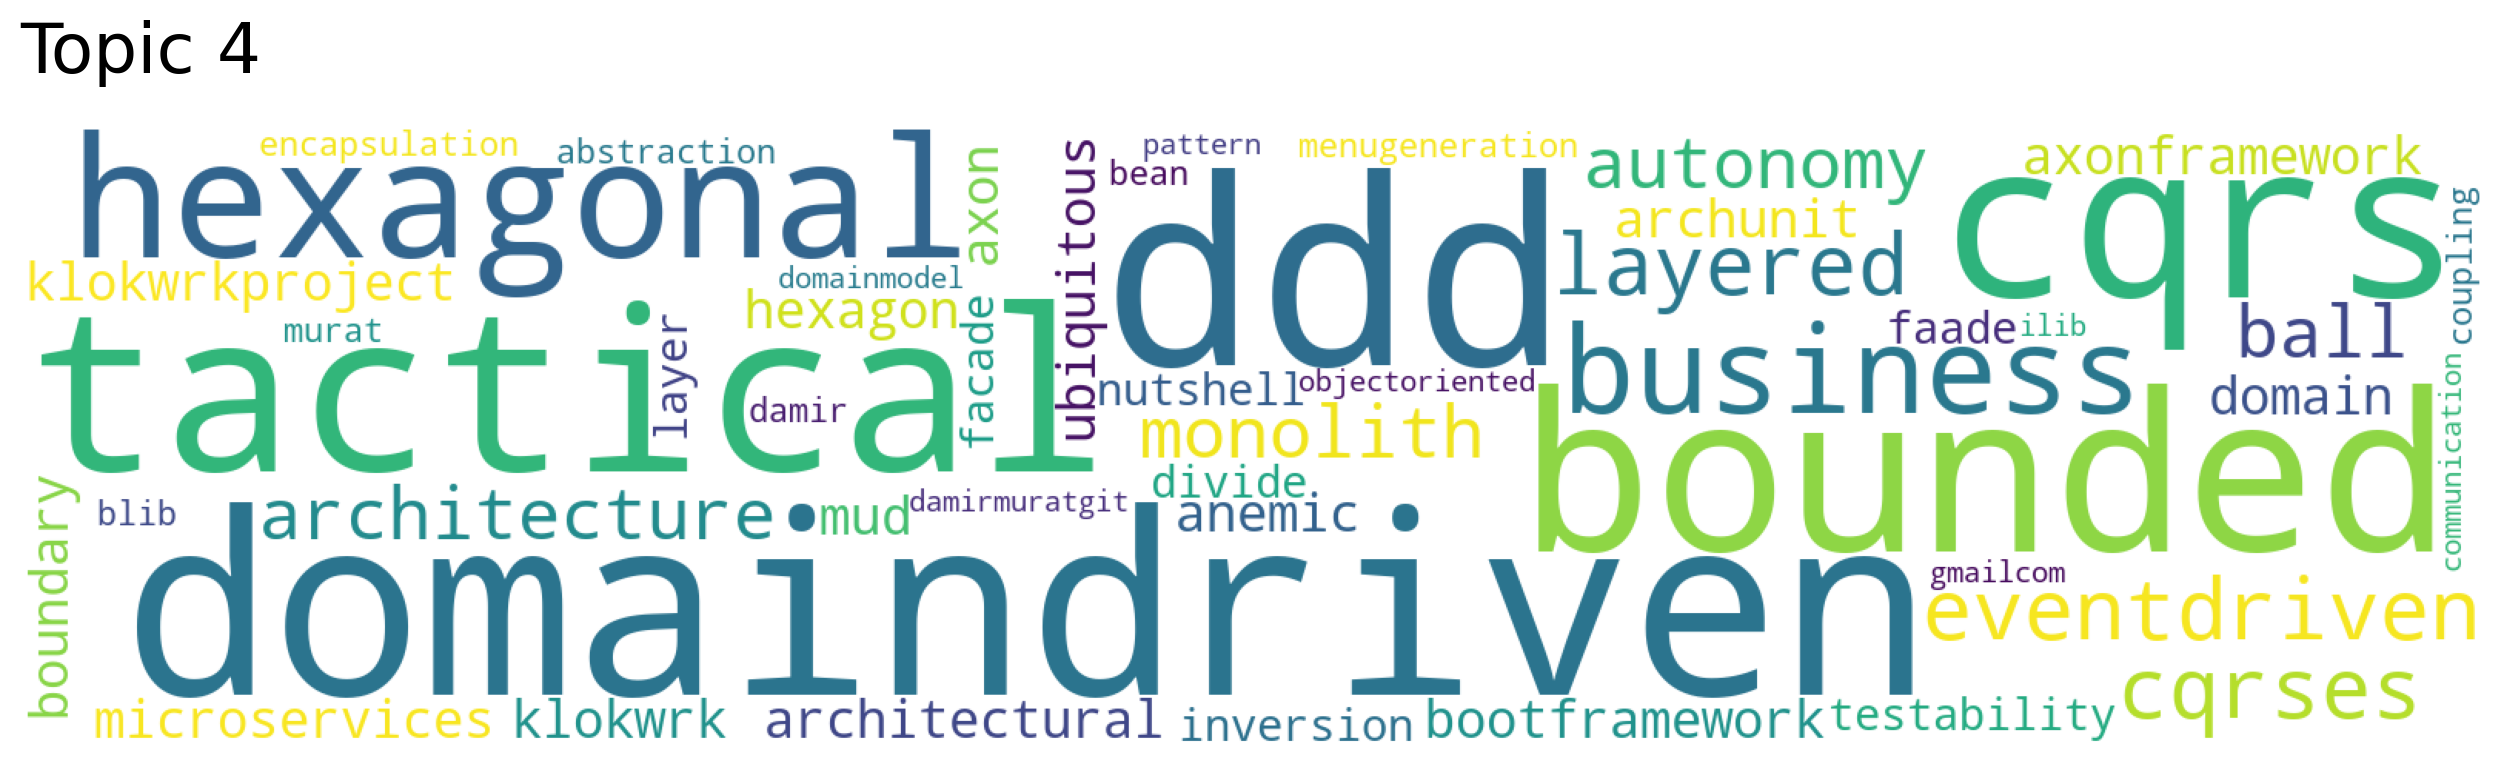

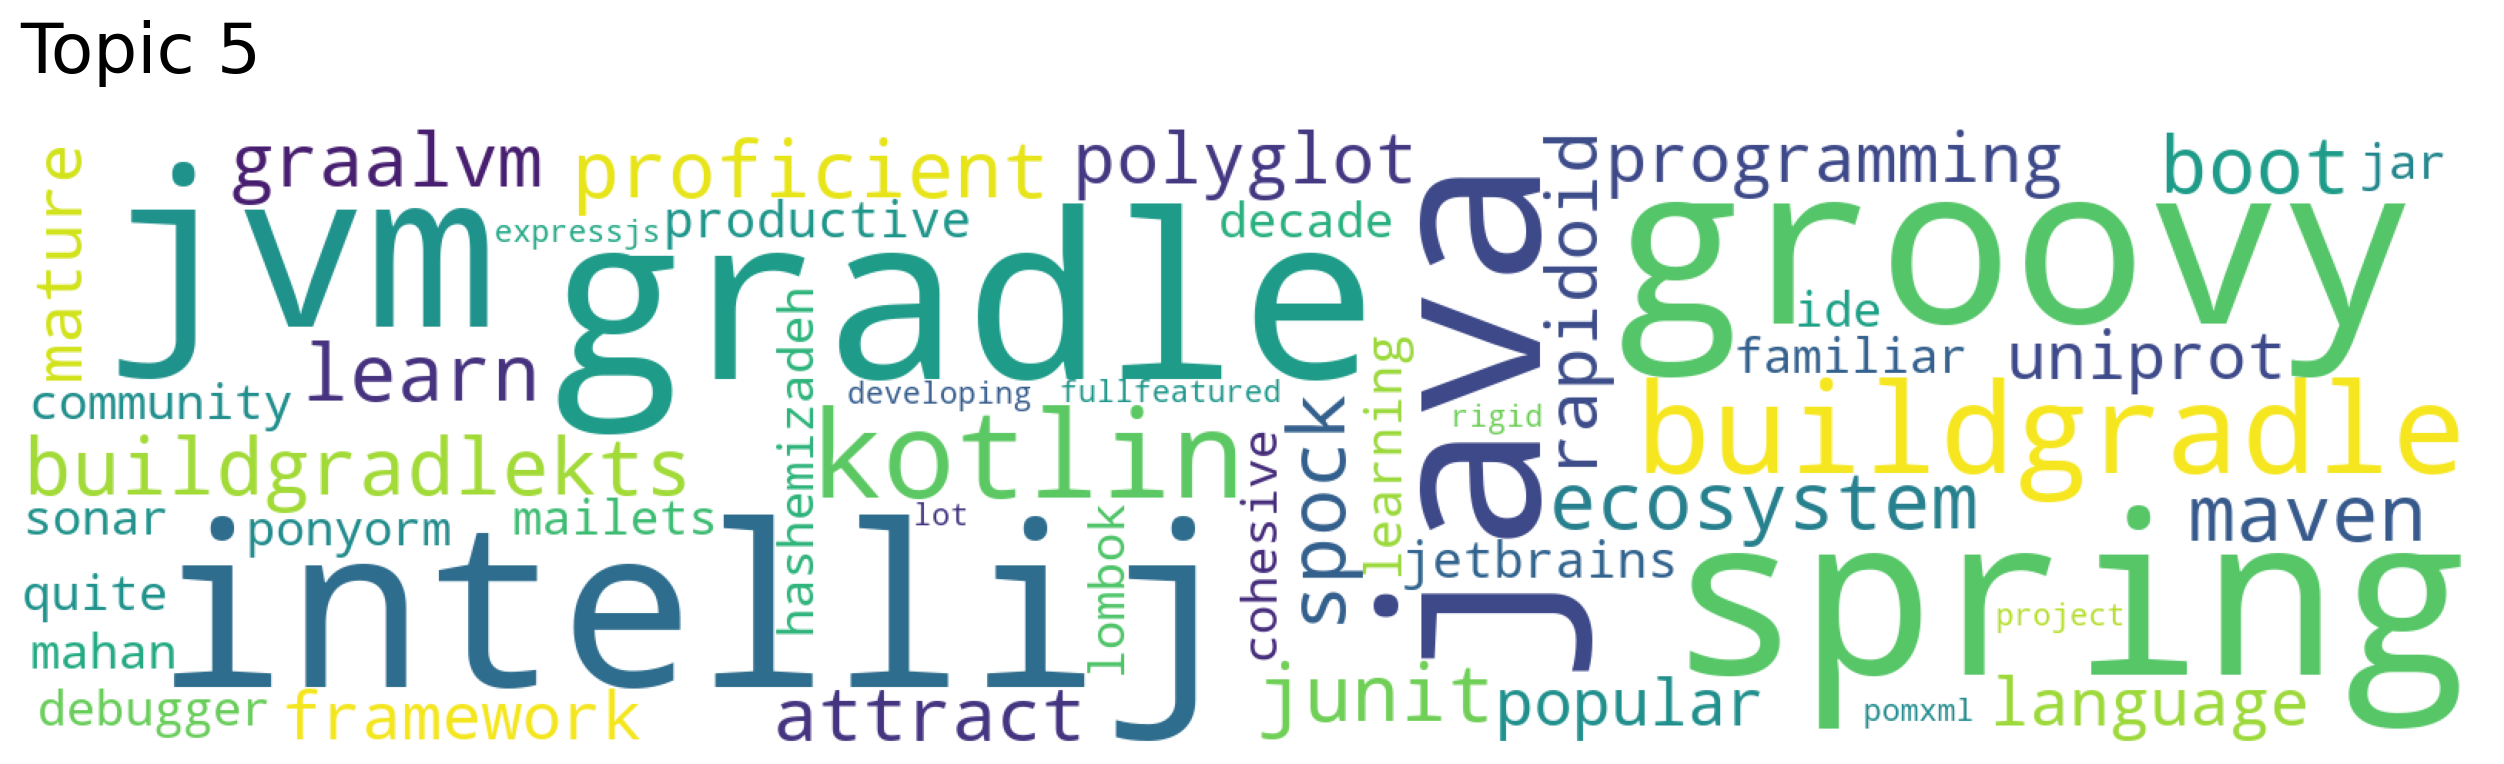

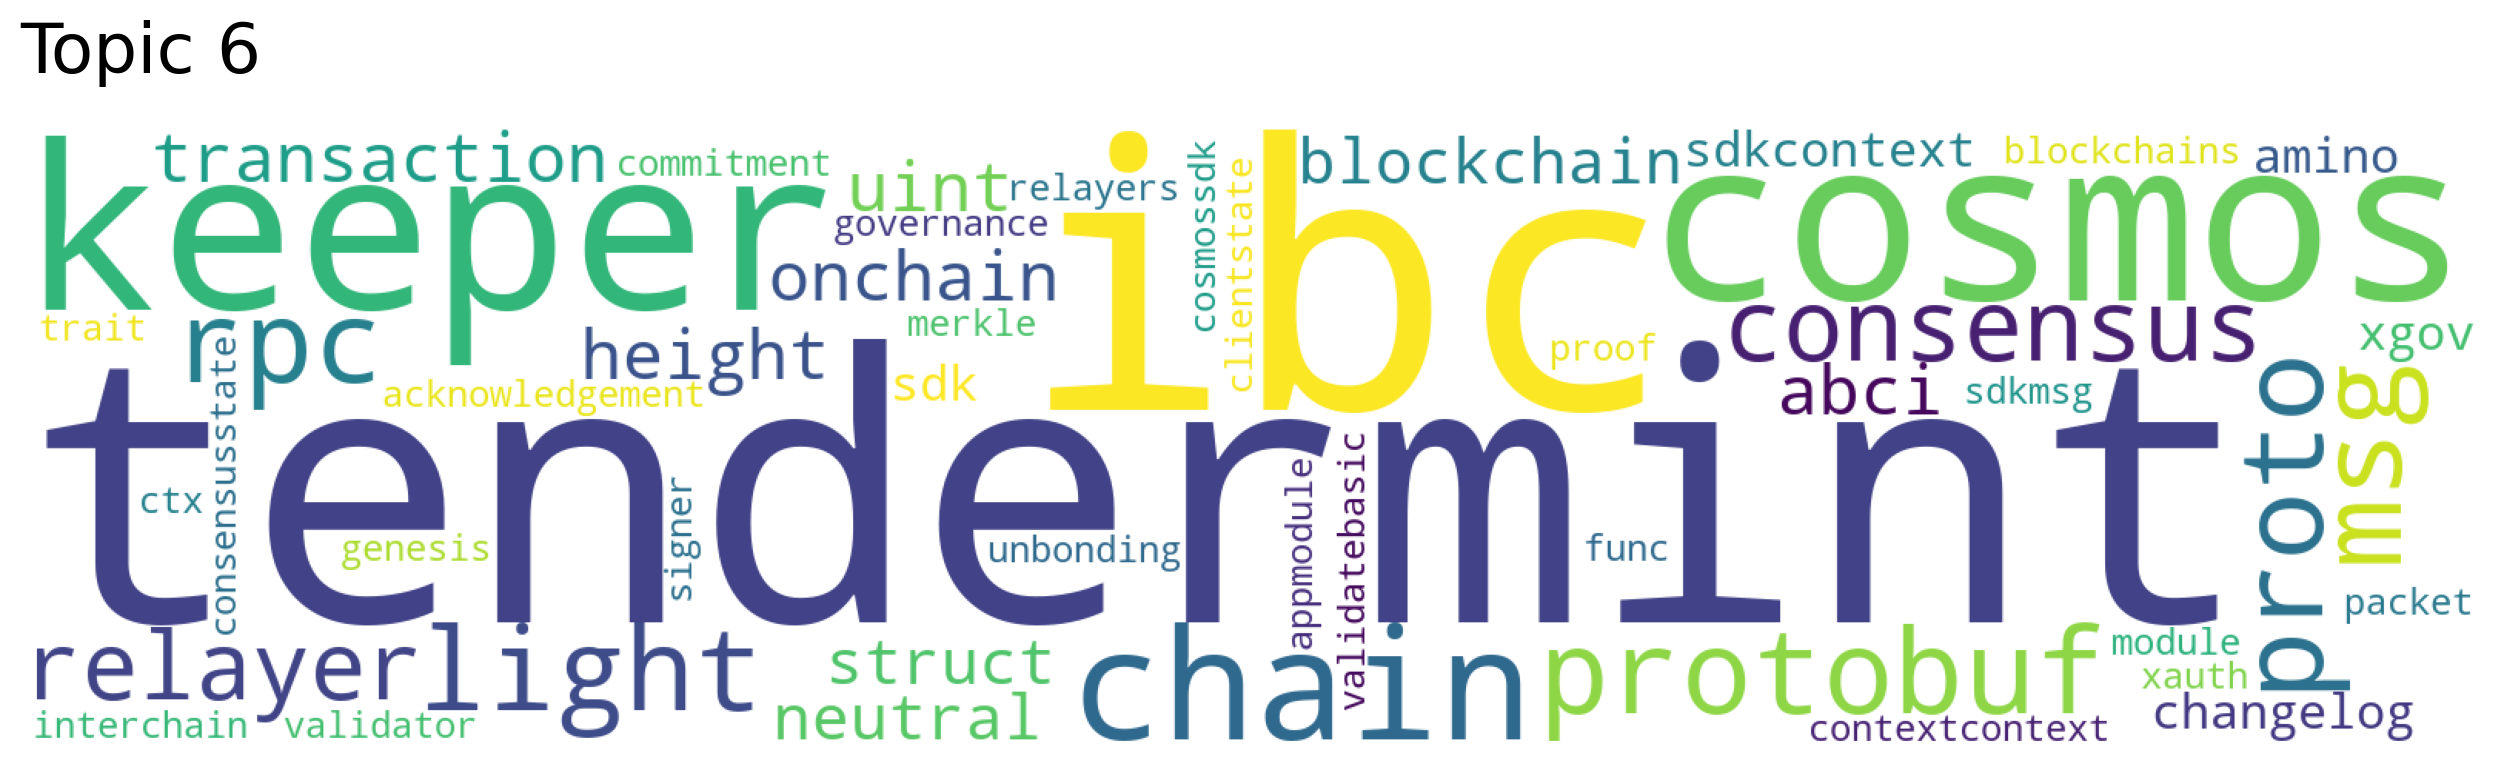

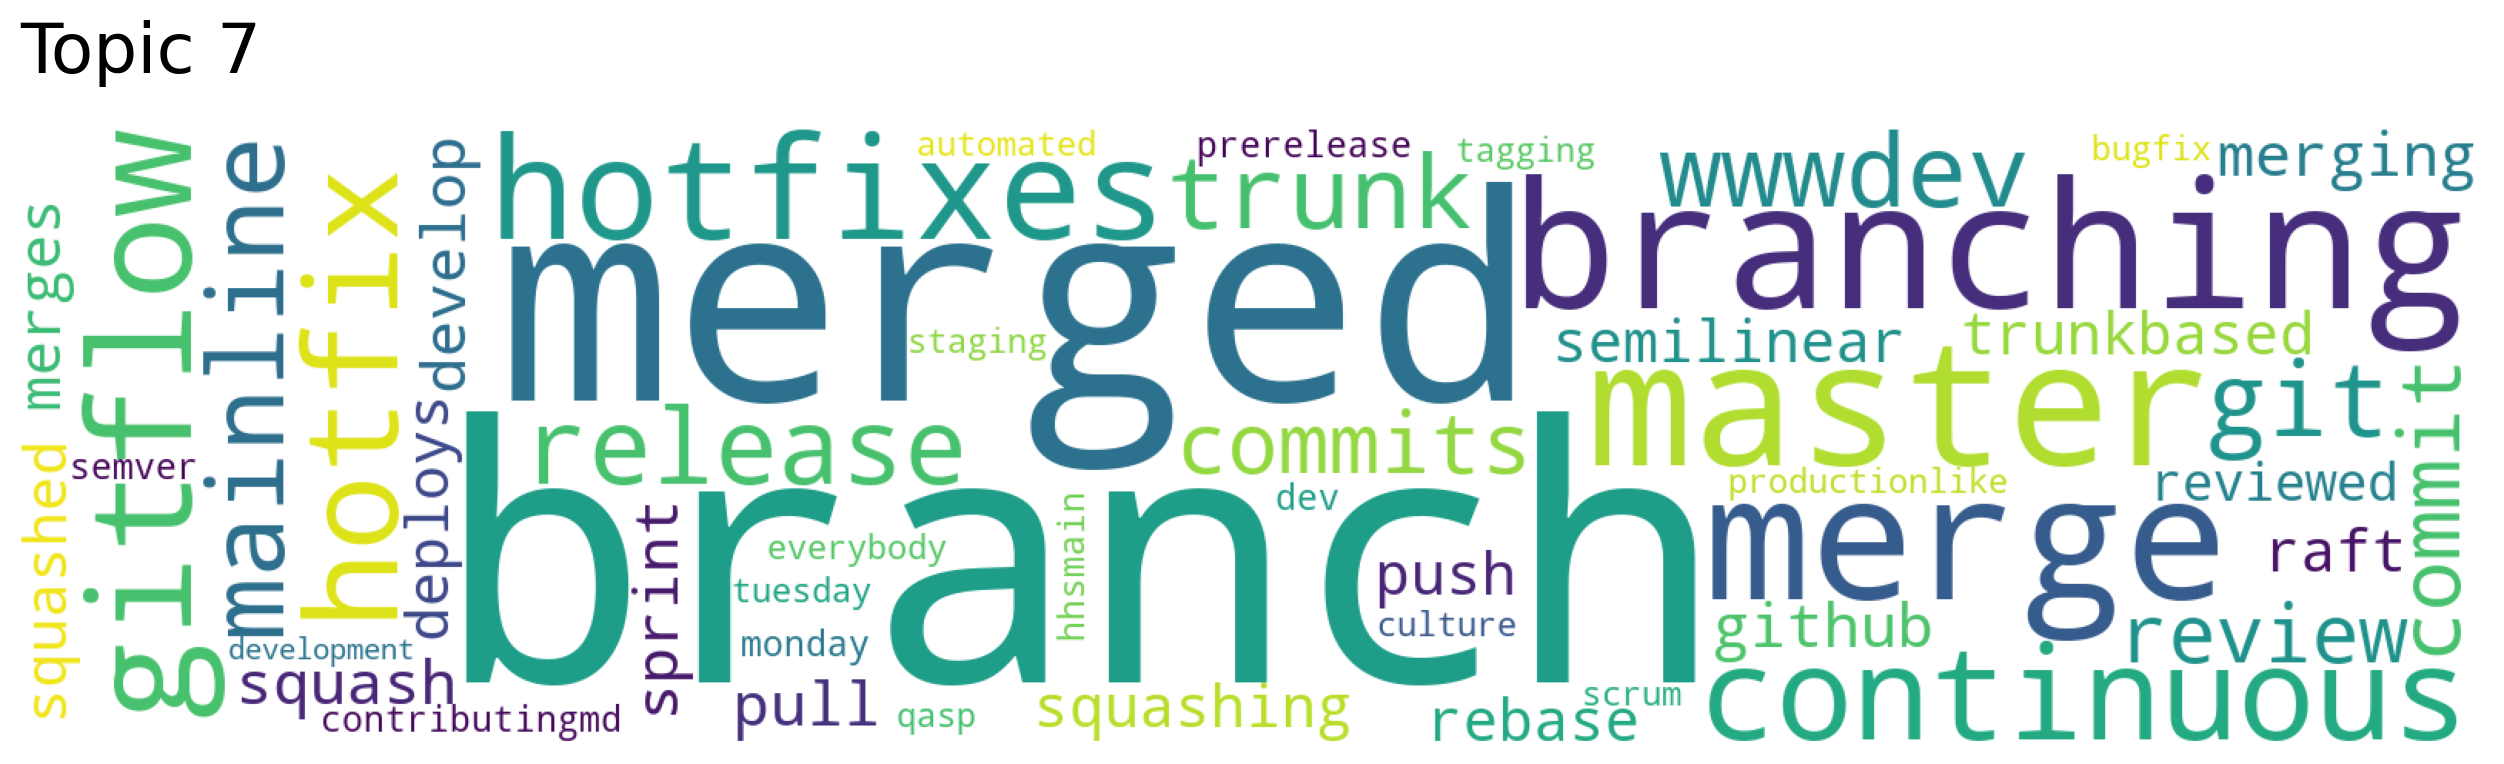

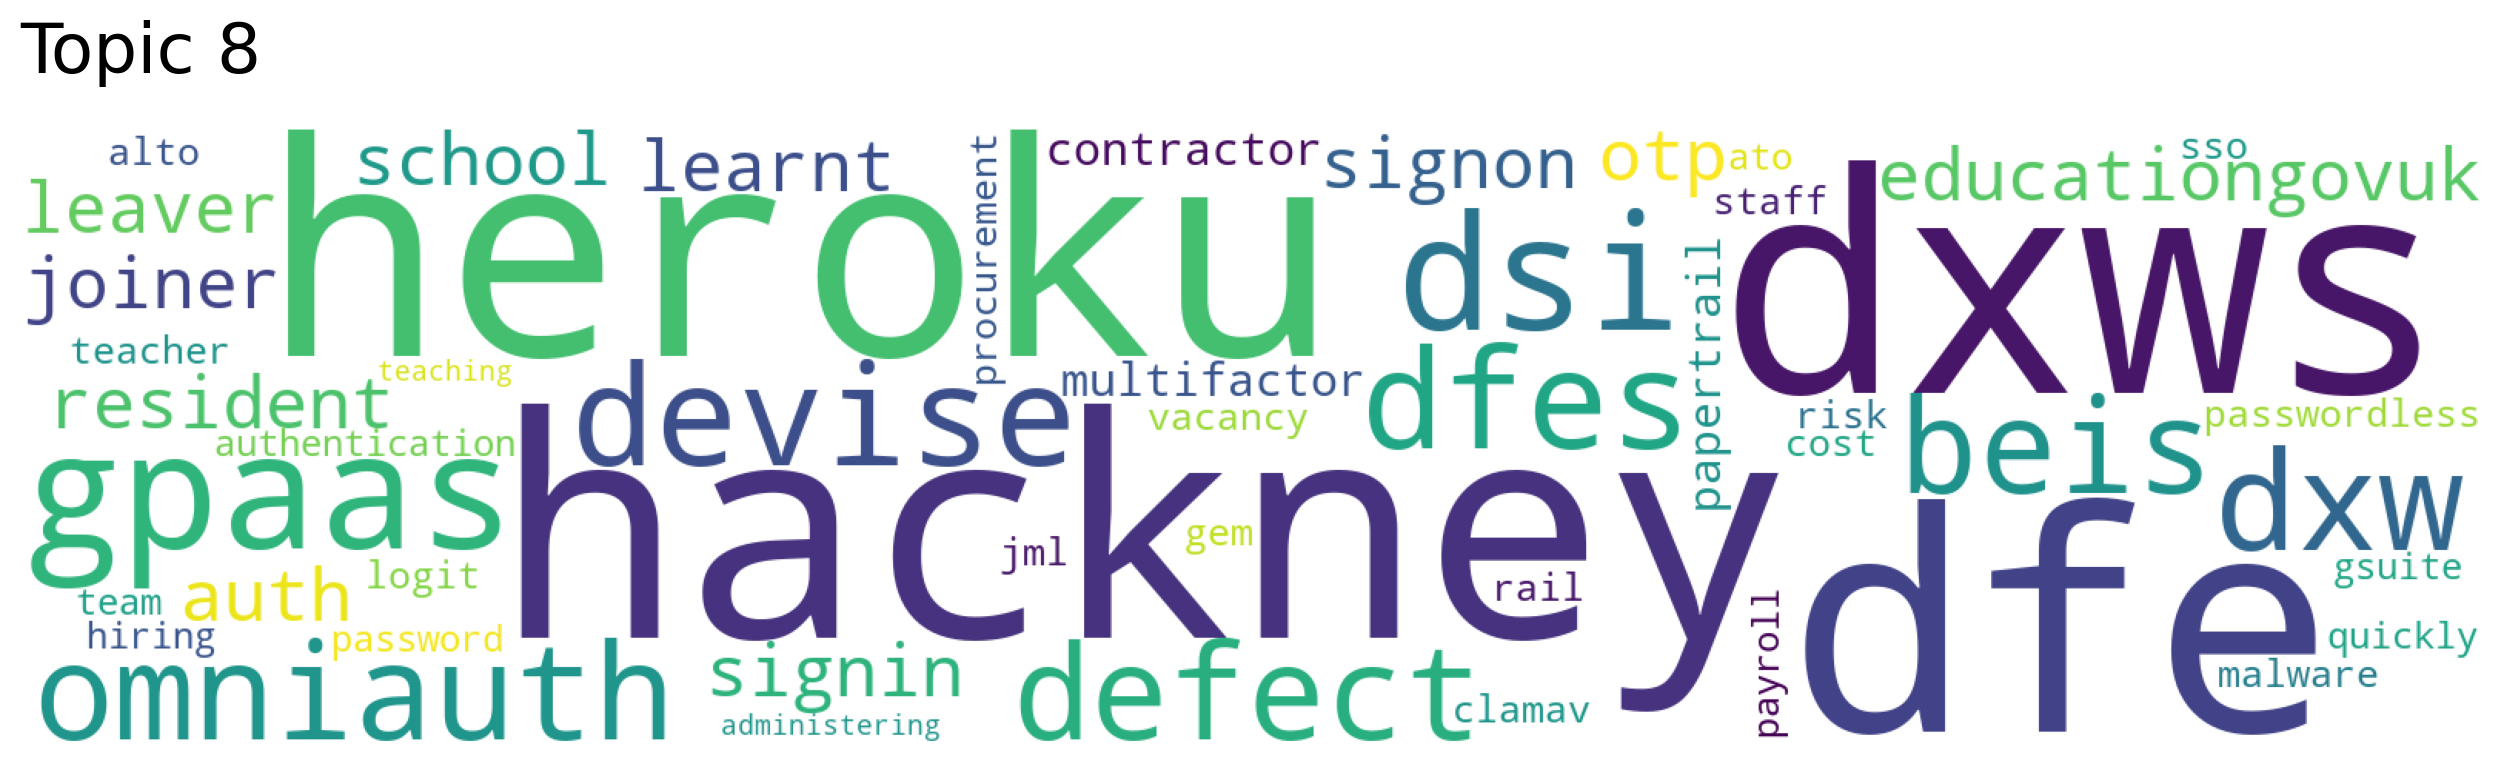

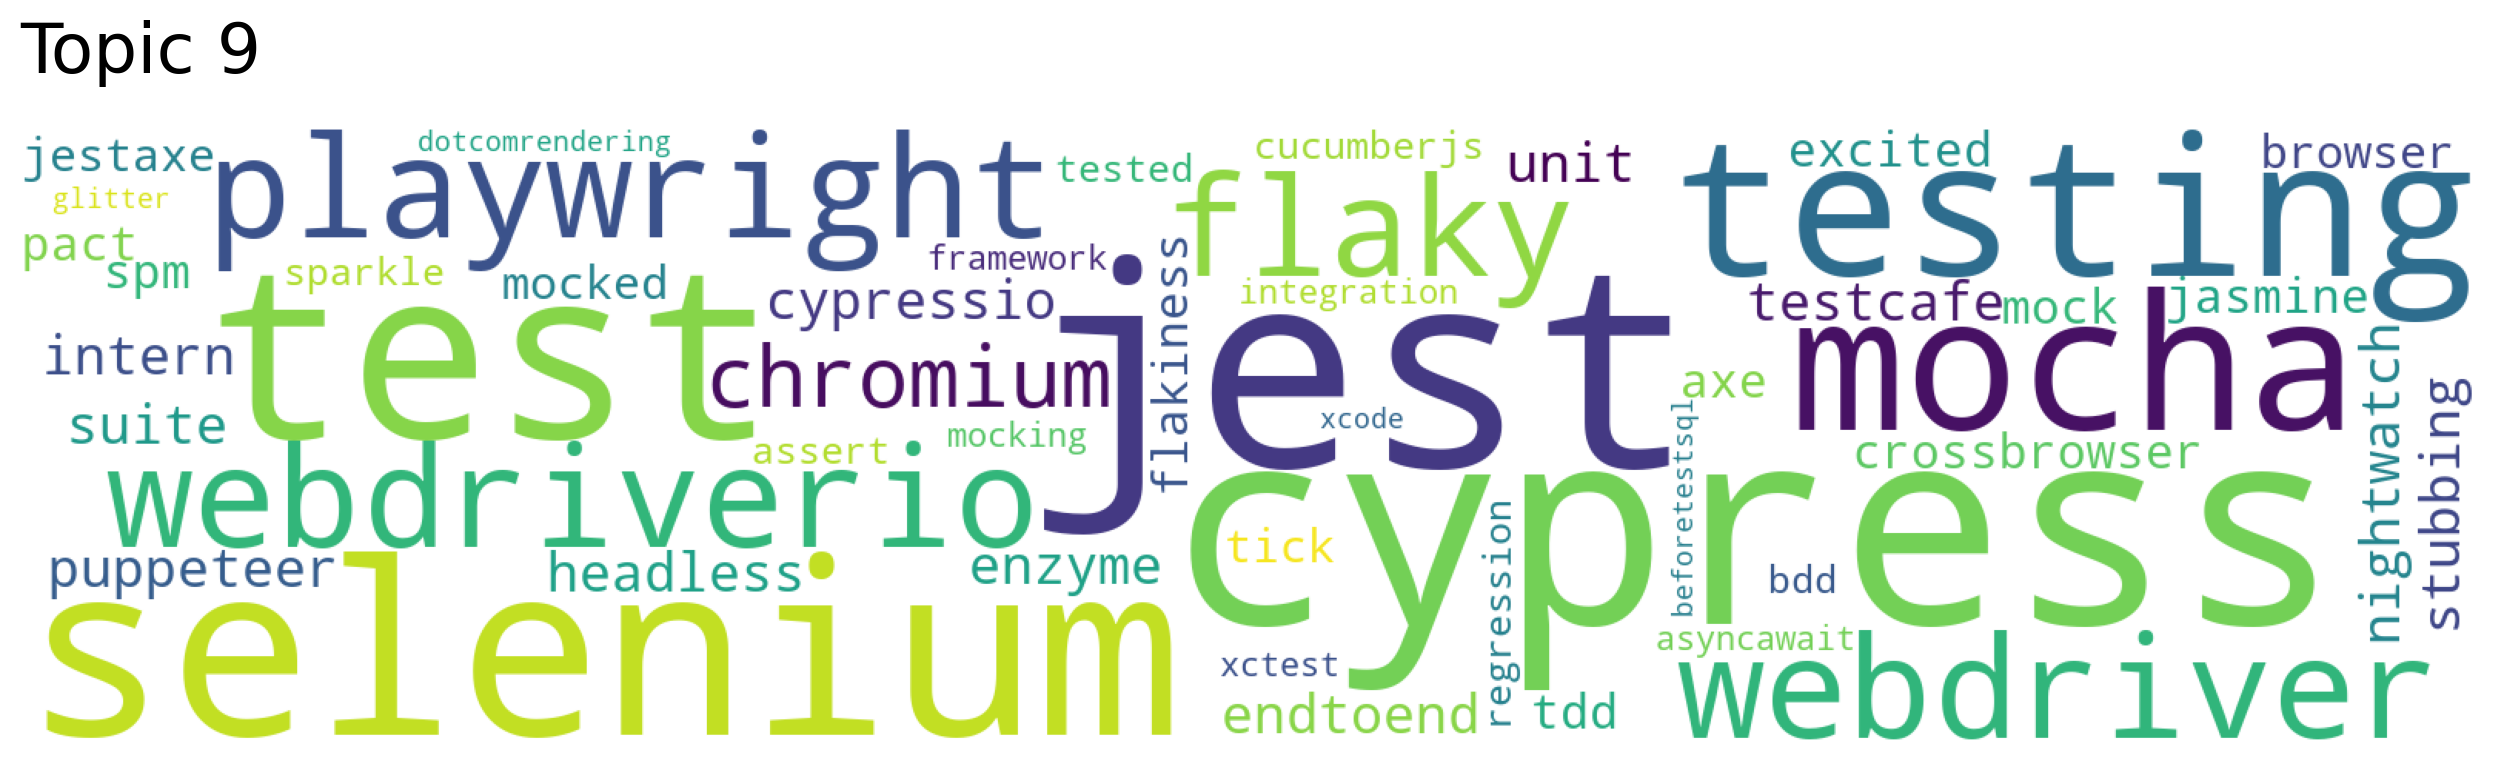

In [13]:
# Get the top 5 words for each topic
topics = model.get_topics(reduced=True)
for i, (words, scores, topic_num) in enumerate(zip(topics[0], topics[1], topics[2])):
    print(f"Topic {i+1}:")
    print(", ".join(words[:10]))

topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

# generate wordclouds
for topic in topic_nums:
    model.generate_topic_wordcloud(topic, background_color='white')